# Simulations

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
#import sys
#sys.path.append('../')
#import src as my
#from src.visualization import visualizeX
#from src.MarkovModel import MarkovModel
#import importlib
#importlib.reload(my)
#importlib.reload(my.common_stat)
#importlib.reload(my.analysis)

## Algorithms

In [2]:
def compute_flight_metric(data, 
                            selected_rows = None,
                            flight = 'flight',
                            muid = 'RAWMUID',
                            seg = 'Segment',
                            metric = 'metric',
                            metric_type = 'single average'):
    ''' 
    compute metric aggregrate for each flight
    
    Args:
        data          - the pandas dataframe [RAWMUID, Segment, flight, metric]    
        selected_rows - a series that shows what rows are selected.
        flight        - flight column name
        muid          - muid column name
        seg           - segment column name
        metric        - metric column name
        metric_type   - string, sum, single average, double average, or proportion
    Returns:
        out           - dataframe [flight, metric_name]
    '''
    if flight not in data.columns or \
        muid not in data.columns or \
        seg not in data.columns or \
        metric not in data.columns:
        raise ValueError('flight/muid/seg/metric is not found in data.columns')
    if selected_rows is not None:
        filtered = data[selected_rows]
    else:
        filtered = data
    if metric_type == 'sum':
        prepare = filtered.groupby([muid, flight])[metric].sum().reset_index()
        out = prepare.groupby(flight)[metric].mean().to_frame('metric sum').reset_index()
    elif metric_type == 'single average':
        k = len(np.unique(filtered[seg]))
        prepare = (filtered.groupby([muid, flight])[metric].sum() / k).reset_index()
        out = prepare.groupby(flight)[metric].mean().to_frame('metric single average').reset_index()
    elif metric_type == 'double average':
        prepare = filtered.groupby([muid, flight])[metric].mean().reset_index()
        out = prepare.groupby(flight)[metric].mean().to_frame('metric double average').reset_index()
    elif metric_type == 'proportion':
        prepare = ((filtered.groupby([muid, flight])[metric].mean() > 0) * 1).reset_index()
        out = prepare.groupby(flight)[metric].mean().to_frame('metric proportion').reset_index()
    else:
        raise ValueError('metric type (%s) not allowed.'%metric_type)
    return out

In [3]:
def naive_continuous_analysis(data, 
                              treat_flight,
                              control_flight,
                              metric_type = 'single average',
                              difference = 'delta'):
    '''
    Compute the naive continuous analysis
    Args:
        data   - dataframe
        treat_flight - string, treat flight name
        control_flight - string, control flight name
        metric_type - string, the metric type
        difference  - string, delta or delta percentage
    Returns:
        result - a number
    '''

    if treat_flight not in np.unique(data['flight']) or \
        control_flight not in np.unique(data['flight']):
        raise ValueError('treat_flight/cotrol_flight not in data[flight]')
    #print((data['flight'] == 'treat_flight'))
    out = compute_flight_metric(data, 
                                (data['flight'] == treat_flight) | (data['flight'] == control_flight), 
                                metric_type = metric_type)
    treated = float(out.loc[out['flight'] == treat_flight, 'metric ' + metric_type])
    control = float(out.loc[out['flight'] == control_flight, 'metric ' + metric_type])
    if difference == 'delta':
        return treated - control
    elif difference == 'delta percentage':
        return treated / control - 1
def jackknife_continuous_analysis(data, 
                                block_len,
                                treat_flight,
                                control_flight,
                                metric_type = 'single average',
                                difference = 'delta'):
    '''
    Compute the jackknife continuous analysis
    Args:
        data   - dataframe
        block_len - int, length of the block
        treat_flight - string, treat flight name
        control_flight - string, control flight name
        metric_type - string, the metric type
        difference  - string, delta or delta percentage
    Returns:
        result - a number
    '''
    filtered = data[(data['flight'] == treat_flight) | (data['flight'] == control_flight)]
    naive = naive_continuous_analysis(filtered, 
                                      treat_flight = treat_flight, 
                                      control_flight = control_flight, 
                                      metric_type=metric_type, 
                                      difference=difference)
    jackknifed = []
    for i in range(min(data['Segment']), max(data['Segment']) - block_len + 2):
        out = compute_flight_metric(filtered, 
                                    (filtered['Segment'] < i) | (filtered['Segment'] >= i + block_len),
                                    metric_type = metric_type)
        treated = float(out.loc[out['flight'] == treat_flight, 'metric ' + metric_type])
        control = float(out.loc[out['flight'] == control_flight, 'metric ' + metric_type])
        if difference == 'delta':
            jackknifed.append(treated - control)
        elif difference == 'delta percentage':
            jackknifed.append(treated / control - 1)
        else:
            raise ValueError('difference (%s) is not allowed.'%difference)
    if (max(data['Segment']) + 1 - min(data['Segment']))%block_len != 0:
        raise ValueError('block_len (%d) should divide the range of the experiment (%d, %d).'%(block_len, max(data['Segment']), min(data['Segment'])))
    stepsize = (max(data['Segment']) + 1 - min(data['Segment']))/block_len - 1
    return (naive - (np.mean(jackknifed) - naive) * stepsize)

def block_bootstrap_continuous_analysis(data, 
                                        treat_flight,
                                        control_flight,
                                        block = 1,
                                        metric_type = 'single average',
                                        difference = 'delta',
                                        repeat = 10):
    '''
    Compute the jackknife continuous analysis
    Args:
        data   - dataframe
        block_len - int, length of the block
        treat_flight - string, treat flight name
        control_flight - string, control flight name
        block - number, size of a block
        metric_type - string, the metric type
        difference  - string, delta or delta percentage
        repeat - string, number of bootstrap samples
    Returns:
        result - a number
    '''
    days = np.arange(min(data['Segment']), max(data['Segment'])+1)
    naive = naive_continuous_analysis(data, 
                                      treat_flight = treat_flight, 
                                      control_flight = control_flight, 
                                      metric_type=metric_type, 
                                      difference=difference)
    tmp = []
    for _ in range(repeat):
        heads = sorted(np.array([x + np.arange(block) for x in np.random.choice(days[0:(len(days) - block + 1)], len(days)//block)]).flatten())
        bootstrapping_day = pd.DataFrame({'Segment':heads, 'NewSeg':np.arange(len(heads))})
        bootstrapping_data = pd.merge(bootstrapping_day, data, on='Segment')
        bootstrapping_data['Segment'] = bootstrapping_data['NewSeg']
        tmp.append(naive_continuous_analysis(bootstrapping_data, 
                                             treat_flight = treat_flight, 
                                             control_flight = control_flight, 
                                             metric_type=metric_type,
                                             difference=difference))
    return (naive * 2 - np.mean(tmp))

def block_bootstrap_fixed_analysis(data, 
                                   admission,
                                   observation,
                                   treat_flight,
                                   control_flight,
                                   block = 1,
                                   metric_type = 'single average',
                                   difference = 'delta',
                                   repeat = 10):
    '''
    Compute the bootstrap continuous analysis
    Args:
        data   - dataframe
        admission - int, admission period
        observation - int, observation period
        block - int, length of the block
        treat_flight - string, treat flight name
        control_flight - string, control flight name
        block - number, size of a block
        metric_type - string, the metric type
        difference  - string, delta or delta percentage
        repeat - string, number of bootstrap samples
    Returns:
        result - a number
    '''
    days = np.arange(min(data['Segment']), max(data['Segment'])+1)
    naive = naive_fixed_duration_analysis(data, 
                                          observation = observation,
                                          admission = admission,
                                          treat_flight = treat_flight, 
                                          control_flight = control_flight, 
                                          metric_type=metric_type, 
                                          difference=difference)
    tmp = []
    for _ in range(repeat):
        heads = sorted(np.array([x + np.arange(block) for x in np.random.choice(days[0:(len(days) - block + 1)], len(days)//block)]).flatten())
        bootstrapping_day = pd.DataFrame({'Segment':heads, 'NewSeg':np.arange(len(heads))})
        bootstrapping_data = pd.merge(bootstrapping_day, data, on='Segment')
        bootstrapping_data['Segment'] = bootstrapping_data['NewSeg']
        tmp.append(naive_fixed_duration_analysis(bootstrapping_data, 
                                                 admission = admission,
                                                 observation = observation,
                                                 treat_flight = treat_flight, 
                                                 control_flight = control_flight, 
                                                 metric_type=metric_type, 
                                                 difference=difference))
    return (naive * 2 - np.mean(tmp))

## Simulation 1

In [4]:
def sim_user_outcome(num_days, freq_dist, treat_name, control_name, num_people):
    ''' Simualte a user outcome
    '''
    raw = []
    # generate treatment
    for i in range(num_people):
        pi = np.random.choice(freq_dist)
        for j in range(num_days):
            if np.random.rand() < pi:
                raw.append([j, i, treat_name, 1 + pi * 1 + np.random.normal(scale=.01)])
    # generate control
    for i in range(num_people, 2 * num_people):
        pi = np.random.choice(freq_dist)
        for j in range(num_days):
            if np.random.rand() < pi:
                raw.append([j, i, control_name, 1 + np.random.normal(scale=.01)])
    data = pd.DataFrame(columns=['Segment', 'RAWMUID', 'flight', 'metric'], data=raw)
    return(data)

continuous analysis : 0.0260(0.0025)
jackknife analysis : 0.0034(0.0028)
bootstrap analysis : 0.0129(0.0026)


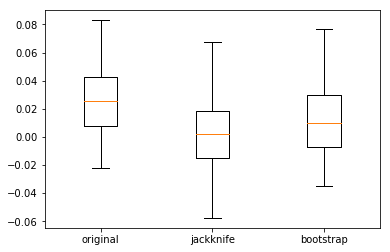

In [5]:
num_sim = 100
k = 14
naive = []
jackknife_est = []
bootstrap = []
truth = 1/3
difference = 'delta'
metric_type = 'single average'
for trial in range(num_sim):
    data = sim_user_outcome(k, np.random.uniform(size = (1000,)), 'T', 'C', 1000)
    # experiment naive
    naive.append(naive_continuous_analysis(data, 'T', 'C', difference=difference, metric_type=metric_type) - truth)
    # jackknifed
    jackknife_est.append(jackknife_continuous_analysis(data, 
                                          block_len=1, 
                                          treat_flight='T', 
                                          control_flight='C', 
                                          metric_type=metric_type,
                                          difference=difference) - truth)
    # bootstrap
    bootstrap.append(block_bootstrap_continuous_analysis(data, 'T', 'C', difference=difference, metric_type=metric_type) - truth)

plt.boxplot([naive, jackknife_est, bootstrap], labels=['original', 'jackknife', 'bootstrap'])
print('continuous analysis : %.4f(%.4f)'%(np.mean(naive), np.std(naive)/len(naive)**.5)) # continuous analysis mean
print('jackknife analysis : %.4f(%.4f)'%(np.mean(jackknife_est), np.std(jackknife_est)/len(jackknife_est)**.5)) # jackknife mean
print('bootstrap analysis : %.4f(%.4f)'%(np.mean(bootstrap), np.std(bootstrap)/len(bootstrap) ** .5))

## Simulation 2

In [6]:
def sim_user_outcome(num_days, freq_dist, treat_name, control_name, num_people):
    ''' Simualte a user outcome
    '''
    raw = []
    # generate treatment
    for i in range(num_people):
        pi = np.random.choice(freq_dist)
        used_days = 0
        for j in range(num_days):
            if np.random.rand() < pi:
                used_days += 1
                raw.append([j, i, treat_name, 1 + pi * (1 + 1/(10 * used_days)) + np.random.normal(scale=.01)])
    # generate control
    for i in range(num_people, 2 * num_people):
        pi = np.random.choice(freq_dist)
        for j in range(num_days):
            if np.random.rand() < pi:
                raw.append([j, i, control_name, 1 + np.random.normal(scale=.01)])
    data = pd.DataFrame(columns=['Segment', 'RAWMUID', 'flight', 'metric'], data=raw)
    return(data)

continuous analysis : 0.0341(0.0025)
jackknife analysis : 0.0096(0.0029)
bootstrap analysis : 0.0197(0.0028)


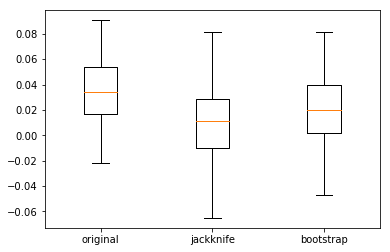

In [7]:
num_sim = 100
k = 14
naive = []
jackknife_est = []
bootstrap = []
truth = 1/3
difference = 'delta'
metric_type = 'single average'
for trial in range(num_sim):
    data = sim_user_outcome(k, np.random.uniform(size = (1000,)), 'T', 'C', 1000)
    # experiment naive
    naive.append(naive_continuous_analysis(data, 'T', 'C', difference=difference, metric_type=metric_type) - truth)
    # jackknifed
    jackknife_est.append(jackknife_continuous_analysis(data, 
                                          block_len=1, 
                                          treat_flight='T', 
                                          control_flight='C', 
                                          metric_type=metric_type,
                                          difference=difference) - truth)
    # bootstrap
    bootstrap.append(block_bootstrap_continuous_analysis(data, 'T', 'C', difference=difference, metric_type=metric_type) - truth)

plt.boxplot([naive, jackknife_est, bootstrap], labels=['original', 'jackknife', 'bootstrap'])
print('continuous analysis : %.4f(%.4f)'%(np.mean(naive), np.std(naive)/len(naive)**.5)) # continuous analysis mean
print('jackknife analysis : %.4f(%.4f)'%(np.mean(jackknife_est), np.std(jackknife_est)/len(jackknife_est)**.5)) # jackknife mean
print('bootstrap analysis : %.4f(%.4f)'%(np.mean(bootstrap), np.std(bootstrap)/len(bootstrap) ** .5))